This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/datasets.ipynb)



# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [2]:
import math
import numpy as np
import pandas as pd
import webdataset as wds # pip install webdataset

from typing import Tuple, List, Callable
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm # pip install tqdm
from slugify import slugify # pip install python-slugify
from warnings import warn
from pathlib import Path

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Features

Here we prove that the feature extractor implemented (using a [Gammatone
Filterbank](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/gammatone/))
works as expected.


We will use the same audio file as in the [original
implementation](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/)
(A matlab C extension).


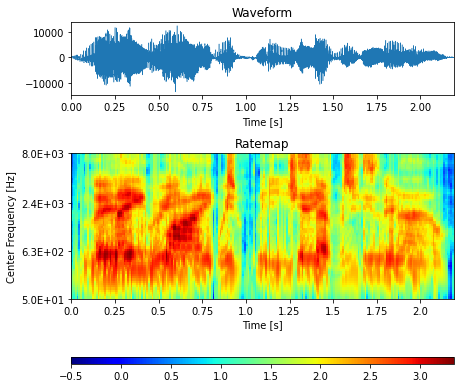

In [4]:
audio_url = (
    r"https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources"
    r"/ratemap/t29_lwwj2n_m17_lgwe7s.wav"
    )
data, sample_rate = ao.io.wave_read(audio_url)
frame_length = 10  # [ms]
frame_samples = int(
    np.ceil(frame_length / 1000 * sample_rate)
    )  # samples per frame
fig, axs = plt.subplots(
    3, 1, figsize=(6.5, 5.5), gridspec_kw={'height_ratios': [0.5, 1, 0.05]}
    )
# Signal
ao.plot.signal(data, sample_rate, ax=axs[0])
axs[0].set_title('Waveform')
# Gammatonegram
frame_length = 10  # [ms]
frame_samples = math.ceil(frame_length / 1000 * sample_rate)
plot, _ = ao.plot.gammatonegram(
    data,
    sample_rate,
    frame_samples,
    num_features=64,
    low_Hz=50,
    high_Hz=8000,
    pcolormesh_kwargs={
        'cmap': 'jet',
        'vmin': -0.5
        },
    ax=axs[1]
    )
axs[1].set_title('Ratemap')
fig.colorbar(plot, cax=axs[2], orientation="horizontal")
fig.tight_layout()

One can see that our implementation corresponds with the example found in the
original implementation.

![Ratemap](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/ratemap.png)


# Wheel Test Bed Experiments


## Experiment 0

In order to gather some data and test our initial hypothesis, we decided to
carry a simple experimetn with a single wheel test bed.

In [5]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-0"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT0'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:127: UserWarning: Could not parse VAO_2022-03-08_17-12-37 from VAO_2022-03-08_17-12-37, item VAO_2022-03-08_17-12-37 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))
c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:127: UserWarning: Could not parse VAO_2022-03-08_17-11-21 from VAO_2022-03-08_17-11-21, item VAO_2022-03-08_17-11-21 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))


In [6]:
# TODO show gammatonegram for some recordings

In [7]:
def plot_primitive_experiment(audio_file, ax=None):
    data, sample_rate = ao.io.wave_read(audio_file)
    frame_length = 500  # [ms]
    frame_samples = int(
        np.ceil(frame_length / 1000 * sample_rate)
        )  # samples per frame
    return ao.plot.gammatonegram(
        data,
        sample_rate,
        frame_samples,
        num_features=64,
        low_Hz=0,
        high_Hz=22050,
        pcolormesh_kwargs={
            'cmap': 'jet',
            'vmin': -1
            },
        ax=ax
        )

In [8]:
data = pd.DataFrame.from_dict(recordings, orient='index')

In [9]:
# w_data = {}
# for c in data.values():
#     w_data[c['w']] = w_data.get(c['w'], []) + [c]
# fig, axs = plt.subplots(
#     len(w_data), max([len(v) for v in w_data.values()]), figsize=(15, 10)
#     )
# row = -1
# last_w = None
# for folder, experiment in data.items():
#     if last_w != experiment['w']:
#         row += 1
#         col = 0
#     else:
#         col += 1
#     last_w = experiment['w']
#     plot, ax = plot_primitive_experiment(
#         folder / 'audio0crop.wav', ax=axs[row, col]
#         )
#     ax.set_title(
#         ', '.join(
#             f"{k}={experiment[k]} {naming[k].get('unit', '')}"
#             for k in naming.keys()
#             )
#         )
# fig.colorbar(plot, cax=axs[-1, -1])
# fig.tight_layout()

## Experiment 1

In this experiment we improved the sensor setup, synchronization and control
with respect to the [Experiment 0](#experiment-0). This experiment was used to
develop a proof of concept for the Acoustic Odometry.

In [10]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT1'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

In [11]:
sample_recording = list(recordings.keys())[1]

def get_recording_ground_truth(recording: Path) -> pd.DataFrame:
    """Gets the ground truth of a training recording from its control file

    Args:
        recording (Path): Path to a training recording folder. Its
            corresponding control file must be located in the parent folder
            and have the same name as the recording folder.

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'ms', 'X',
            'Vx', 'Vw', 'slip', 'wheel_rotation' and 'timestamp' as index.
    """
    gt = pd.read_csv(
        recording.parent / (recording.name + '.csv'),
        index_col='timestamp',
        usecols=['timestamp', 'ms', 'X', 'Vx', 'Vw', 'slip', 'wheel_rotation'],
        )
    # Remove the first row from the dataframe, the velocity there is useless
    gt = gt.iloc[1:, :]
    return gt


sample_gt = get_recording_ground_truth(sample_recording)
sample_gt.iloc[35:45]

,ms,X,Vx,Vw,slip,wheel_rotation
timestamp,,,,,,
1.651142e+09,3600,123.67,0.0358,19.791,-0.036406,70.625
1.651142e+09,3701,127.13,0.0346,19.220,-0.031439,72.547
1.651142e+09,3801,130.33,0.0320,20.954,0.125000,74.643
1.651142e+09,3901,133.35,0.0302,18.936,0.086242,76.536
1.651142e+09,4001,136.42,0.0307,20.183,0.128480,78.555
1.651142e+09,4101,139.87,0.0345,20.107,0.016906,80.565
1.651142e+09,4201,143.25,0.0338,19.827,0.023269,82.548
1.651142e+09,4301,146.82,0.0357,19.763,-0.034973,84.524
1.651142e+09,4401,150.69,0.0387,20.746,-0.068797,86.599


In [12]:
def get_weighted_average(
    data: pd.DataFrame,
    var: str,
    start_timestamp: float,
    end_timestamp: float,
    ) -> float:
    df = data.loc[(data.index > start_timestamp) &
                  (data.index <= end_timestamp), [var, 'ms']]
    if df.empty:
        return 0
    # Weighted average of the Vx values giving more importance to the most
    # recent
    return (df[var] * df['ms']).sum() / df['ms'].sum()


get_weighted_average(
    sample_gt, 'Vx', sample_gt.iloc[35].name, sample_gt.iloc[40].name
    )

0.03239230966418867

In [13]:
# TODO plot control data with labels for some segments

In [14]:
# TODO plot gammatonegram with the wheeltestbed control Vx

## Experiment 2

In [15]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_2 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_2)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
DATASETS_FOLDER = EXPERIMENT_FOLDER / 'datasets'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

In [16]:
import inspect
func = lambda x: get_Vx(x, 0, 0.5) \
    + 2
inspect.getsource(func)

'func = lambda x: get_Vx(x, 0, 0.5) \\\n    + 2\n'

In [17]:
def generate_dataset(
    recordings: List[Path],  # [Path(G:\WTB\rec\w_5.0;s_0.0), ...]
    name: str,
    frame_features: int = 256,
    frame_duration: int = 10,  # [milliseconds]
    frames_per_segment: int = 100,
    overlap_ratio: float = 0.8,
    *,
    datasets_folder: Path = DATASETS_FOLDER,
    extractors: List[Tuple[ao.extractor.Extractor, dict]] = [
        (ao.extractor.GammatoneFilterbank, {}),
        ],
    ) -> Path:
    # Check input
    if not datasets_folder.is_dir():
        raise ValueError(
            f"datasets_folder must be a directory, not {output_folder}"
            )
    output_folder = Path(datasets_folder) / name
    output_folder.mkdir(exist_ok=True, parents=True)
    # Check if the output folder has already a dataset
    if any(output_folder.glob('transform_None;*.tar')):
        warn(f"Dataset already exists at {output_folder}")
        return output_folder
    segment_duration = frame_duration * frames_per_segment
    segment_overlap = int(segment_duration * overlap_ratio)
    # Save dataset generation data in yaml file inside output folder
    ao.io.yaml_dump(
        {
            'recordings': [r.name for r in recordings],
            'frame_features': frame_features,
            'frame_duration': frame_duration,
            'frames_per_segment': frames_per_segment,
            'overlap_ratio': overlap_ratio,
            'segment_duration': segment_duration,
            'segment_overlap': segment_overlap,
            'extractors': {
                i: [e.__name__, kwargs]
                for i, (e, kwargs) in enumerate(extractors)
                },
            },
        to_file=output_folder / "transform_None.yaml",
        )
    # Progress bars
    progress = {
        'recording':
            tqdm(total=len(recordings), desc='Recordings', unit='folders'),
        'file':
            tqdm(desc='microphone?', unit='files'),
        'segment':
            tqdm(desc='Segments', unit='segments'),
        }
    extractors_by_sample_rate = {}  # {sample_rate: [extractor, ...]}
    writers_by_device = {}  # {config['name']: (ShardWriter, config)}
    # Iterate over recording folders
    for r_idx, recording in enumerate(recordings):
        # Wheel test bed control data
        try:
            ground_truth = get_recording_ground_truth(recording)
        except FileNotFoundError:
            warn("Skip: No control data found for recording " + recording.name)
            continue
        # Iterate over audio recordings
        wav_files = list(recording.glob('microphone*.wav'))
        progress['file'].reset(len(wav_files))
        for wav_file in wav_files:
            # Read data
            progress['file'].set_description(wav_file.name)
            wav_data, sample_rate = ao.io.wave_read(wav_file)
            config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
            if sample_rate != config['samplerate']:
                warn(f"Skip: Sample rate mismatch for {wav_file.name}")
                continue
            frame_samples = int(frame_duration * sample_rate / 1000)
            # Get corresponding extractors
            try:
                _extractors = extractors_by_sample_rate[sample_rate]
            except KeyError:
                _extractors = extractors_by_sample_rate[sample_rate] = [
                    _class(
                        num_samples=frame_samples,
                        num_features=frame_features,
                        sample_rate=sample_rate,
                        **_kwargs
                        ) for _class, _kwargs in extractors
                    ]
            # Get corresponding writer
            device_name = slugify(config['name'])
            try:
                writer, device_config = writers_by_device[device_name]
                # Check that the device configuration is the same. File
                # configuration has start and end timestamps apart from the
                # device configuration.
                if device_config.items() <= config.items():
                    warn(
                        f"Configuration mismatch for {wav_file.name}:"
                        f"\nExpected {device_config}\nGot {config}"
                        )
            except KeyError:
                writer = wds.ShardWriter(
                    str(
                        output_folder /
                        f"transform_None;device_{device_name};shard_%03d.tar"
                        )
                    )
                device_config = {
                    k: v
                    for k, v in config.items() if 'timestamp' not in k
                    }
                writers_by_device[device_name] = (writer, device_config)
                ao.io.yaml_dump(
                    device_config, output_folder / f"device_{device_name}.yaml"
                    )
            # Process audio segments
            start = config['start_timestamp']
            segments = ao.dataset.audio.segment(
                wav_data, sample_rate, segment_duration, segment_overlap
                )
            progress['segment'].reset(total=len(segments))
            for idx, segment in enumerate(segments):
                end = start + segment_duration / 1000
                # TODO Use all extractors
                features = ao.dataset.audio.features(
                    segment, frame_samples, _extractors[0]
                    )
                writer.write({
                    '__key__':
                        f"transform_None;device_{device_name};"
                        f"recording_{r_idx};segment_{idx}",
                    'features.pyd': features,
                    **{
                        f"{var}.pyd": get_weighted_average(
                            ground_truth, var, start, end
                            )
                        for var in ['Vx', 'Vw', 'slip']
                        },
                    })
                start = end - segment_overlap / 1000
                progress['segment'].update()
            progress['file'].update()
        progress['recording'].update()
    for writer, _ in writers_by_device.values():
        writer.close()
    for progress_bar in progress.values():
        progress_bar.close()
    return output_folder


dataset_path = generate_dataset(
    list(recordings.keys())[0:1],
    'test_wds',
    )

Recordings:   0%|          | 0/1 [00:00<?, ?folders/s]

microphone?: 0files [00:00, ?files/s]

Segments: 0segments [00:00, ?segments/s]

# writing G:\Shared drives\VAO [Andreu's Thesis]\VAO_WheelTestBed-Experiment-2\datasets\test_wds\transform_None;device_laptop-built-in-microphone;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO [Andreu's Thesis]\VAO_WheelTestBed-Experiment-2\datasets\test_wds\transform_None;device_rode-smartlav-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO [Andreu's Thesis]\VAO_WheelTestBed-Experiment-2\datasets\test_wds\transform_None;device_rode-smartlav-wheel-axis;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO [Andreu's Thesis]\VAO_WheelTestBed-Experiment-2\datasets\test_wds\transform_None;device_rode-videomic-ntg-top;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO [Andreu's Thesis]\VAO_WheelTestBed-Experiment-2\datasets\test_wds\transform_None;device_rode-videomic-ntg-front;shard_000.tar 0 0.0 GB 0
# writing G:\Shared drives\VAO [Andreu's Thesis]\VAO_WheelTestBed-Experiment-2\datasets\test_wds\transform_None;device_rode-videomic-ntg-back;shard_000.tar 0 0.0 GB

In [ ]:
dataset = wds.WebDataset([f"file:{p}" for p in dataset_path.glob('*.tar')]
                         ).to_tuple('features', 'vx')
for item in dataset:
    print(type(item))
    print(item.keys())
# sample = next(iter(dataset))

In [ ]:
# TODO augment dataset with callable

## Base

In [ ]:
_ = generate_dataset(
    list(recordings.keys()),
    'exp01_simple_dataset',
    extractors=[
        (
            ao.extractor.GammatoneFilterbank, {
                'transform': lambda x: np.log10,
                'low_Hz': 50,
                'high_Hz': 8000,
                'temporal_integration': 0
                }
            ),
        ],
    )

## Features

## Double channel

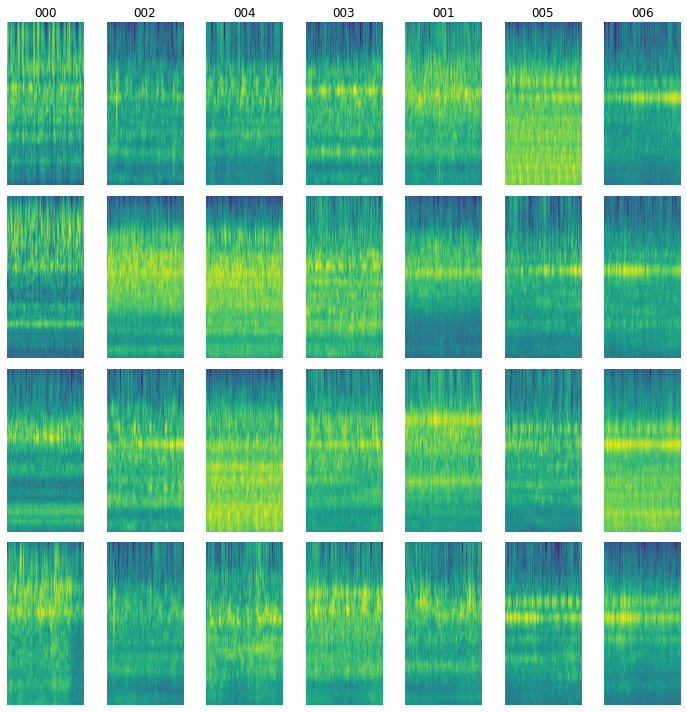

In [32]:
import random
import matplotlib.image as mpimg


def plot_features_dataset(dataset_folder: Path):
    label_folders = list(dataset_folder.iterdir())
    samples = 4
    fig, axs = plt.subplots(samples, len(label_folders), figsize=(10, 10))
    for i, label_folder in enumerate(label_folders):
        images = list(label_folder.iterdir())
        for k, image in enumerate(random.sample(images, samples)):
            axs[k, i].imshow(mpimg.imread(image))
            # make xaxis invisible
            axs[k, i].xaxis.set_visible(False)
            # make spines (the box) invisible
            plt.setp(axs[k, i].spines.values(), visible=False)
            # remove ticks and labels for the left axis
            axs[k, i].tick_params(left=False, labelleft=False)
        axs[0, i].set_title(label_folder.name)
    fig.tight_layout()


plot_features_dataset(DATASETS_FOLDER / 'initial_cnn_samples')